# Cellular automata heterogeneous traffic simulation

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
#from tqdm import tqdm
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.weight'] = 'ultralight'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['mathtext.default'] = 'regular'
#mpl.rcParams['figure.figsize'] = (10,10)

In [2]:
import pyximport; pyximport.install()  #do we really need this in two places?
from cython_traffic_CA import run_simulation

def single_run(num_lanes, num_places, density, P_lc, time_steady, num_iters, r_hdv, 
                 max_platoon_size, N_c, model, visualise = False):
    pyximport.install()
    from cython_traffic_CA import run_simulation
    return run_simulation(num_lanes, num_places, density, P_lc, time_steady, num_iters, 
                          r_hdv, max_platoon_size, N_c, model, visualise)

## Sequential implemetation

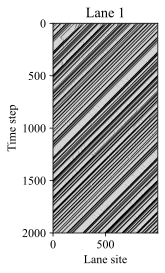

In [3]:
def spatiotemporal_diagramm(num_lanes, num_places, density, P_lc, time_steady, num_iters, R_hdv, max_platoon_size, N_c, 
                             model = 'S-NFS', visualise = True):
    
    flux, change_lane, v_av, episodes_I = single_run(num_lanes, num_places, density, P_lc, time_steady, num_iters, R_hdv, max_platoon_size, N_c, model, visualise)
    episodes = np.asarray(episodes_I)
    for lane in range(num_lanes):
        indicator = int('1' + str(num_lanes) + str(lane+1))
        plt.subplot(indicator)
        plt.title('Lane ' + str(lane+1))
        plt.xlabel('Lane site')
        plt.ylabel('Time step')
        plt.tight_layout()
        plt.imshow(episodes[lane], cmap="Greys", interpolation="None") #"None" "nearest"
    plt.savefig("spatiotemp.tiff", dpi=300, format="tiff")
    plt.show()
    
spatiotemporal_diagramm(num_lanes = 1, num_places = 1000, density = 0.5, P_lc = 0.0, time_steady = 500, 
                         num_iters = 1500, R_hdv = 1.0, max_platoon_size = 5, N_c = 0, model = 'S-NFS', visualise = True)

In [7]:
def fundamental_diagram_seq(num_lanes, num_places, density_steps, P_lc, time_steady, time_iters, 
                                 r_hdv, max_platoon_size, R, model):
    '''
    Returns data (density, flux and lane change rate arrays) for drawing a fundamental diagram.
    num_lanes (int) - number of lanes in the road;
    num_places (int) - number of sites (or cells) in each lane;
    density_steps (int) - number of steps in density between [0,1];
    time_iters (int) -  number of time iterarions.
    '''
    
    density_range = np.linspace(0.0, 1.0, density_steps)
    
    flux_ar = np.zeros(density_steps)
    change_lane = np.zeros(density_steps)
    v_av_ar = np.zeros(density_steps)
    
    for i in tqdm(range(density_steps)):
        N_c = int(R*density_range[i]*num_lanes*num_places)
        flux_ar[i], change_lane[i], v_av_ar[i] = single_run(num_lanes, num_places, density_range[i], P_lc, time_steady, 
                                                            time_iters, r_hdv, max_platoon_size, N_c, model,
                                                            visualise = False)   
    return density_range, flux_ar, change_lane, v_av_ar

def draw_fundamental_diagram_seq(num_lanes, num_places, density_steps, P_lc, time_steady, time_iters, r_hdv, 
                                 max_platoon_size_list, R, model):
    r, flux, CLR, v_av = [], [], [], []
    M = []
    k = 0
    print("Draw fundamental diagramm routine has begun:")
    for max_platoon_size in tqdm(max_platoon_size_list):
        r.append(None); flux.append(None); CLR.append(None); v_av.append(None)
        r[k], flux[k], CLR[k], v_av[k] = fundamental_diagram_seq(num_lanes, num_places, density_steps, P_lc, 
                                                                 time_steady, time_iters, r_hdv, max_platoon_size, R, model)
        M.append(1.0 - flux[k]/(5*num_lanes*r[k]+1e-10))
        #r[k] *= 1000.0/7.5 #dim in veh per km
        #flux[k] *= 3600 #dim in veh per hour
        k += 1
    
    single_plot(x = r, y = flux, var_list = max_platoon_size_list, var_name = '$S$', \
                title = 'Fundamental diagram', x_label = 'Normalized densit', y_label = 'Normalized flow')
    single_plot(x = r, y = CLR, var_list = max_platoon_size_list, var_name = '$S$', \
                title = 'Lane changing rate', x_label = 'Normalized density', \
                y_label = 'Lane changing rate per cell')
    single_plot(x = r, y = v_av, var_list = max_platoon_size_list, var_name = '$S$', \
                title = 'Average velocity', x_label = 'Normalized density', \
                y_label = 'average velocity')
    single_plot(x = r, y = M, var_list = max_platoon_size_list, var_name = '$S$', \
                title = 'Order parameter', x_label = 'Normalized density', \
                y_label = 'Order parameter')
    
def single_plot(x, y, var_list, var_name, title, x_label, y_label):
    marks_dots = ['ko', 'rv', 'g^', 'bs', 'mx', 'b>', 'r*'] #fix it - only finite number
    marks_lines = ['k-', 'r-', 'g-', 'b-', 'm-', 'b--', 'r--'] #fix it - only finite number
    labels = []
    for i in range(len(var_list)):
        labels.append(var_name + ' = ' + str(var_list[i]))

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    for i in range(len(var_list)):
        plt.plot(x[i], y[i], marks_dots[i], label = labels[i], markersize=2)
    plt.legend()
    plt.savefig(title + ".tiff", dpi=300, format="tiff")
    plt.show()

Draw fundamental diagramm routine has begun:


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

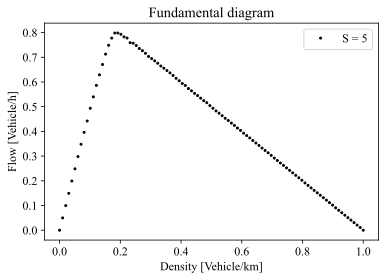

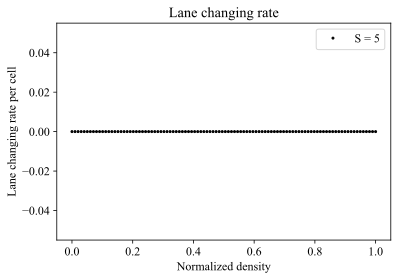

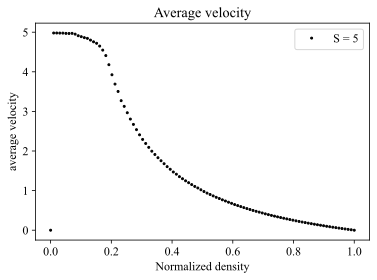

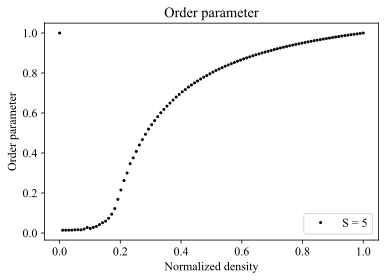

Program running time is t = 62.761429299999996 s


In [5]:
t0 = time.perf_counter()

draw_fundamental_diagram_seq(num_lanes = 1, num_places = 1000, density_steps = 100, P_lc = 0.5, time_steady = 250, 
                         time_iters = 250, r_hdv = 1.0, max_platoon_size_list = [5], R = 0.0, model = 'S-NFS')
t1 = time.perf_counter() - t0
print("Program running time is t =", t1, "s")

## Parallel implementation

In [4]:
from distributed import Client, LocalCluster

hello = LocalCluster(n_workers = 12, threads_per_worker = 1)
client = Client(hello)

client

Client Scheduler: tcp://127.0.0.1:2605 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 15.82 GiB


In [5]:
def fundamental_diagram_parallel(num_lanes_r, num_cells_r, density_range, P_lc_r, time_steady_r, time_iters_r, 
                                 r_hdv_r, max_platoon_size_r, N_c_r, model_r):
    '''
    Returns data (density, flux and lane change rate arrays) for drawing a fundamental diagram.
    num_lanes (int) - number of lanes in the road;
    num_places (int) - number of sites (or cells) in each lane;
    density_steps (int) - number of steps in density between [0,1];
    time_iters (int) -  number of time iterarions.
    '''
    density_steps = len(density_range)
    flux_ar = np.zeros(density_steps)
    change_lane = np.zeros(density_steps)
    v_av_ar = np.zeros(density_steps)
   
    futs = client.map(single_run, num_lanes_r, num_cells_r, density_range, P_lc_r, \
                      time_steady_r, time_iters_r, r_hdv_r, max_platoon_size_r, N_c_r, model_r, pure = False)
    results = client.gather(futs)
    
    for i in range(density_steps):
        flux_ar[i], change_lane[i], v_av_ar[i] = results[i]
    
    return density_range, flux_ar, change_lane, v_av_ar


#def draw_fundamental_diagram_parallel(num_lanes, num_places, density_steps, P_lc, time_steady, time_iters, 
#                             r_hdv, max_platoon_size_list, R, model):
    
def draw_fundamental_diagram_parallel(num_lanes, num_places, density_steps, P_lc, time_steady, time_iters, 
                             r_hdv_list, max_platoon_size, R, model):
    
    density_range = np.linspace(0.0, 1.0, density_steps)
    
    if model == 'W184':
        V_max = 1
    else:
        V_max = 5 #in case you need order parameter - fix this valus
    
    r, flux, CLR, v_av, M = [], [], [], [], []
    k = 0
    
    variable = 'HDV ratio'
    
    # initialize arrays for parallel implementation
    model_r = []
    for i in range(len(density_range)):
        model_r.append(model)
        
    num_lanes_r = np.full(density_steps, num_lanes, dtype = int)
    num_cells_r = np.full(density_steps, num_places, dtype = int)
    time_steady_r = np.full(density_steps, time_steady, dtype = int)
    time_iters_r = np.full(density_steps, time_iters, dtype = int)
    N_c_r = (R*density_range*num_lanes*num_places).astype(int)
    P_lc_r = np.full(density_steps, P_lc)
    max_platoon_size_r = np.full(density_steps, max_platoon_size, dtype = int) #uncom if r_hdv varies
    #r_hdv_r = np.full(density_steps, r_hdv)  #uncom if max_platoon_size varies
    
    print("Draw fundamental diagramm routine has begun:")
    
    if variable == 'Max platoon size':
        v_name = '$S$'
        for max_platoon_size in tqdm(max_platoon_size_list):
            max_platoon_size_r = np.full(density_steps, max_platoon_size, dtype = int)

            r.append(None); flux.append(None); CLR.append(None); v_av.append(None)
            r[k], flux[k], CLR[k], v_av[k] = fundamental_diagram_parallel(num_lanes_r, num_cells_r, density_range, 
                                                                          P_lc_r, time_steady_r, time_iters_r,
                                                                          r_hdv_r, max_platoon_size_r, N_c_r, model_r)
            M.append(1.0 - flux[k]/(V_max*num_lanes*r[k] + 1e-20))
            #r[k] *= 1000.0/7.5 #dim in veh per km
            #flux[k] *= 3600 #dim in veh per hour
            k += 1
            
    elif variable == 'HDV ratio':
        v_name = '$R_{HDV}$'
        for r_hdv in tqdm(r_hdv_list):
            r_hdv_r = np.full(density_steps, r_hdv)
            r.append(None); flux.append(None); CLR.append(None); v_av.append(None)
            r[k], flux[k], CLR[k], v_av[k] = fundamental_diagram_parallel(num_lanes_r, num_cells_r, density_range, 
                                                                          P_lc_r, time_steady_r, time_iters_r,
                                                                          r_hdv_r, max_platoon_size_r, N_c_r, model_r)
            M.append(1.0 - flux[k]/(V_max*num_lanes*r[k] + 1e-20))
            #r[k] *= 1000.0/7.5 #dim in veh per km
            #flux[k] *= 3600 #dim in veh per hour            
            k += 1
    #check down there if you change var list
    single_plot(x = r, y = flux, var_list = r_hdv_list, var_name = v_name, \
                title = 'Fundamental diagram', x_label = 'Density [Vehicle/cell]', y_label = 'Flux [Vehicle/time step]')
    single_plot(x = r, y = CLR, var_list = r_hdv_list, var_name = variable, \
                title = 'Lane change rate', x_label = 'Density [Vehicle/cell]', \
                y_label = 'Lane change rate per cell')
    single_plot(x = r, y = v_av, var_list = r_hdv_list, var_name = v_name, \
                title = 'Average velocity', x_label = 'Density [Vehicle/cell]', y_label = 'average velocity')
    single_plot(x = r, y = M, var_list = r_hdv_list, var_name = v_name, \
                title = 'Order parameter', x_label = 'Density [Vehicle/cell]', y_label = 'Order parameter')  

Draw fundamental diagramm routine has begun:


  0%|          | 0/5 [00:00<?, ?it/s]

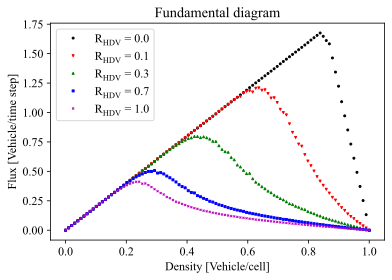

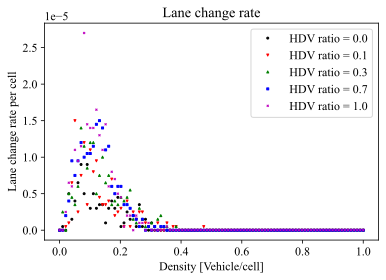

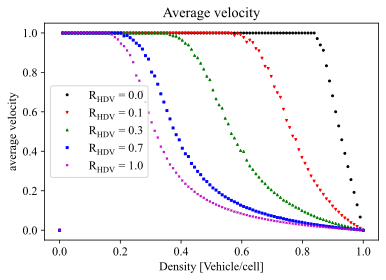

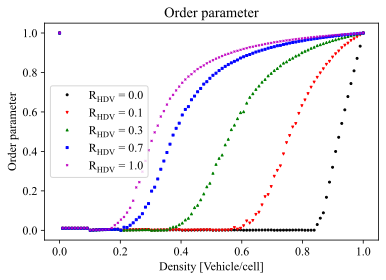

Program running time is t = 846.2081028999999 s


In [8]:
t0 = time.perf_counter()

draw_fundamental_diagram_parallel(num_lanes = 2, num_places = 500, density_steps = 100, P_lc = 0.5, time_steady = 1000, 
                         time_iters = 2000, r_hdv_list = [0.0, 0.1, 0.3, 0.7, 1.0], max_platoon_size = 5, R = 0.0, model = 'W184')

#draw_fundamental_diagram_parallel(num_lanes = 1, num_places = 1000, density_steps = 1000, P_lc = 0.0, time_steady = 2000, 
#                         time_iters = 3000, r_hdv = 0.3, max_platoon_size_list = [0, 1, 5, 10], R = 0.0, model = 'W184')

t1 = time.perf_counter() - t0
print("Program running time is t =", t1, "s")

## Unused (for now) functions, that needs to be modified in order to work properly

In [ ]:
def R_influence_parallel(num_lanes, num_places, P_lc, time_steady, time_iters, R_steps, density):
    '''
    Returns: R_range, flux_ar, v_av_ar
    num_lanes (int) - number of lanes in the road;
    num_places (int) - number of sites (or cells) in each lane;
    density (float from 0 to 1) - density of cars;
    time_iters (int) -  number of time iterarions.
    '''
    flux_ar = np.zeros(R_steps)
    v_av_ar = np.zeros(R_steps)
    
    R_range = np.linspace(0, 0.9, R_steps)
    N_c_r = (R_range*density*num_lanes*num_places).astype(int)
    
    # initialize arrays for parallel implementation
    num_lanes_r = np.full(R_steps, num_lanes, dtype = int)
    num_cells_r = np.full(R_steps, num_places, dtype = int)
    time_steady_r = np.full(R_steps, time_steady, dtype = int)
    time_iters_r = np.full(R_steps, time_iters, dtype = int)
    density_r = np.full(R_steps, density)
    P_lc_r = np.full(R_steps, P_lc)

    futs = client.map(single_run, num_lanes_r, num_cells_r, density_r, P_lc_r, \
                      time_steady_r, time_iters_r, N_c_r, pure = False)
    results = client.gather(futs)
    
    for i in range(R_steps):
        rho, flux_ar[i], change_lane, v_av_ar[i] = results[i]
        
    return R_range, flux_ar, v_av_ar
   
    
def draw_R_inf(num_lanes, num_places, P_lc, time_steady, time_iters, R_steps, density_list):
    R, flux, v_av = [], [], []
    k = 0
    print("R impact diagramm routine has begun:")
    for density in tqdm(density_list):
        R.append(None); flux.append(None); v_av.append(None)
        R[k], flux[k], v_av[k] = R_influence_parallel(num_lanes, num_places, P_lc, time_steady, \
                                             time_iters, R_steps, density)
        k += 1
    
    single_plot(x = R, y = flux, var_list = density_list, var_name = 'density', \
                title = 'R influence', x_label = 'R', y_label ='flow')
    single_plot(x = R, y = v_av, var_list = density_list, var_name = 'density', \
                title = 'R influence', x_label = 'R', y_label ='v average')
       
def draw_them_all(num_lanes, num_places, r_hdv_list, P_lc, time_steady, time_iters, density_steps, R, density, max_platoon_size):
    draw_fundamental_diagram(num_lanes, num_places, density_steps, P_lc, time_steady, time_iters, 
                             r_hdv_list, max_platoon_size, R)
    #draw_R_inf(num_lanes, num_places, P_lc, time_steady, time_iters, R_steps, density_list)